<a href="https://colab.research.google.com/github/ShreyanshBardia/Employee_Attrition_Prediction/blob/main/Copy_of_Documentation_of_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries

In [1]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 27 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 2s (2,012 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 129499 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3

In [2]:
! pip install Pillow
! pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [3]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 15.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


### IMPORTS

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from google.colab.patches import cv2_imshow
from math import ceil
import pytesseract
import easyocr

### COLOR INVARIANCE

In [2]:
def preprocess_invert_image(img:str):
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_height, img_width = img.shape
  counts,bins = np.histogram(img,bins=20) #need to experiment with 10 also
  counts_perc = counts/counts.sum()
  cumsum = counts.cumsum()/counts.sum()
  argmax = counts_perc.argmax()
  perc_left = 1 - counts_perc[argmax]
  if cumsum[argmax-1]/perc_left>=0.50:
    threshold = bins[argmax - 2]
    inv_req = True
  else:
    threshold = bins[argmax + 2 ] 
    inv_req = False
  print(f"{inv_req=}")
  thresh, img_bin = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

  img_bin_inv = img_bin
  if inv_req:
    img_bin_inv = 255 - img_bin
  cv2_imshow(img_bin_inv)
  return img,255-img_bin_inv,img_bin_inv,inv_req
  

### IMPROVED DETECTION

In [12]:

def recognize_rows(img):
  
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # thresh, img_bin = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
    # img_bin_inv = 255 - img_bin
    img,img_bin,img_bin_inv,_ = preprocess_invert_image(img)
    img_height, img_width = (img).shape
    if (img>180).sum()/(img_height* img_width) >= 0.5:
      thresh, img_bin = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)
      img_bin_inv = 255- img_bin
    kernel_len_ver = max(10,img_height // 50)
    kernel_len_hor = max(10, img_width // 50)
    # Defining a vertical kernel to detect all vertical lines of image
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len_ver)) #shape (kernel_len, 1) inverted! xD
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len_hor, 1)) #shape (1,kernel_ken) xD
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin_inv, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=4)
    # Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin_inv, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=4)
    
    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

    # Eroding and thesholding the image
    img_vh = cv2.dilate(img_vh, kernel, iterations=5)
    thresh, img_vh = (cv2.threshold(img_vh, 50, 255, cv2.THRESH_BINARY ))

    bitor = cv2.bitwise_or(img_bin, img_vh)

    img_median = cv2.medianBlur(bitor, 3)

    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_width*2, 1)) #shape (kernel_len, 1) inverted! xD
    horizontal_lines = cv2.erode(img_median, hor_kernel, iterations=1)

    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    # # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 0, horizontal_lines, 1, 0.0)

    # # Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)

    thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY )
    bitxor = cv2.bitwise_xor(img, img_vh)
    bitnot = cv2.bitwise_not(bitxor)

    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)


    # # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

    # Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

    # Get mean of heights
    mean = np.mean(heights)

    # Create list box to store all boxes in
    box = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        box.append([x, y, w, h])

    # Improving the height of rows
    box_new = []
    running_avg = 0
    for id in range(len(box)-1):
      b1,b2 = box[id],box[id+1]
      avg =( ( b2[1] - b1[1] - b1[3] )/2)
      b1[3]+=int(avg*3/4)
      b2[1]-=ceil(avg*5/4)
      b2[3]+=ceil(avg)
      if id == 0:
        b1[1]-=ceil(avg*5/4)
        b1[3]+=ceil(avg)
      if id == len(box)-2:
        b2[3]+=int(avg*3/4)

    for b in box:
      x, y, w, h = b
      image = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return box,img_median,img

In [13]:

def recognize_cols(img_median,img):
    img_height, img_width = img_median.shape


    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, img_height*2)) #shape (kernel_len, 1) inverted! xD
    vertical_lines = cv2.erode(img_median, ver_kernel, iterations=1)

    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_width*2, 1)) #shape (kernel_len, 1) inverted! xD
    horizontal_lines = cv2.erode(img_median, hor_kernel, iterations=1)
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

    # # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 1, horizontal_lines, 0, 0.0)

    # # Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)

    thresh, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY )
    bitxor = cv2.bitwise_xor(img, img_vh)
    bitnot = cv2.bitwise_not(bitxor)

    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)


    # # Sort all the contours by left to right.
    contours, boundingBoxes = sort_contours(contours, method="left-to-right")

    box = []

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        box.append([x, y, w, h])

    img_width = img.shape[1]

    for id in range(len(box)-1):
      b1,b2 = box[id],box[id+1]
      avg =( ( b2[0] - b1[0] - b1[2] )/2)
      
      b1[2]+=int(avg*3/4)
      b2[0]-=ceil(avg*5/4)
      b2[2]+=ceil(avg)
      
      if id == 0:
        b1[2]+=b1[0]
        b1[0]=0

      if id==len(box)-2:
        b2[2]=img_width-b2[0]
        assert b2[2]+b2[0] == img_width
    # blank = np.ones_like(img)*255
    for b in range(len(box)):
      x, y, w, h = box[b]
      if b!=0 or b!=len(box)-1:
        image = cv2.line(img, (x+w,0), (x+w,img.shape[0]), (0, 255, 0), 2)
        # blank = cv2.line(blank, (x+w,0), (x+w,img.shape[0]), (0, 255, 0), 2)
    try:
      cv2_imshow(image)
      # cv2_imshow(blank)
    except:
      cv2_imshow(img)
      # cv2_imshow(blank)
    return box if len(box)>1 else -1

    

In [14]:
def recognize_structure(read):
  row_boxes,image,img=recognize_rows((read))
  col_boxes = []
  for x,y,w,h in row_boxes: 
    i = (cv2.imread(read)[y:y+h,x:x+w])
    try:
      col_box = recognize_cols(image[y:y+h,x:x+w],img[y:y+h,x:x+w])
      col_boxes.append(col_box)
    except:
      col_boxes.append([])
  return row_boxes,col_boxes


In [23]:
def img_to_table(img_path:str):
  reader = easyocr.Reader(lang_list=["en"])
  row_boxes,col_boxes = recognize_structure(img_path)
  img_bw,img_bin,img_bin_inv,use_tess = preprocess_invert_image(img_path)
  data= []
  d1= [ ]
  for idx,row in enumerate(row_boxes):
    x,y,w,h = row
    d1.append(pytesseract.image_to_string(img_bw[ y:y+h, x:x+w],config="--psm 7"))
    data.append([])
    if col_boxes[idx]!=-1:
      for col in col_boxes[idx]:
        x,_,w,_ = col
        if use_tess:
          # print("Tesseract is being used")
          text = (pytesseract.image_to_string(img_bw[ y:y+h, x:x+w]))
        else:
          text=""
          for detected in (reader.readtext(img_bin[ y:y+h, x:x+w])):
            text += detected[1] 
        data[-1].append(text)
    else:
      if use_tess:
          # print("Tesseract is being used")
          data[-1].append(pytesseract.image_to_string(img_bw[ y:y+h, x:x+w]))
      else:
          for detected in (reader.readtext(img_bin[ y:y+h, x:x+w])):
            text += detected[1] 
  return data,col_boxes,d1

### Experiments

In [16]:
def html_output(img_path:str):
  cv2_imshow(cv2.imread(img_path))
  data,col_boxes = img_to_table(img_path)
  table=""
  for row in data:
    table+="<tr>\n"
    for idx,col in enumerate(row):
      col = col.replace("\n","").replace("\x0c","").replace("!","").replace("|","").title()
      table+=f"<td> {col} </td>\n"
    table+="</tr>\n"
  return (f"<table>\n{table}</table>")

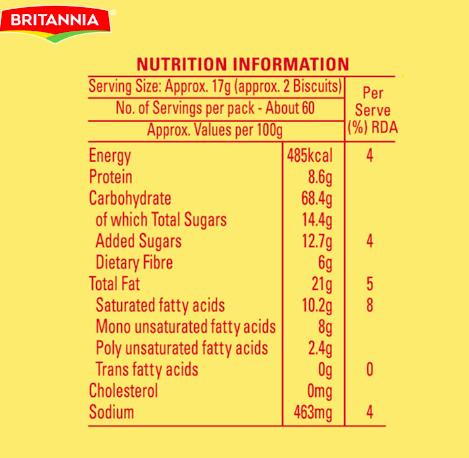

inv_req=True


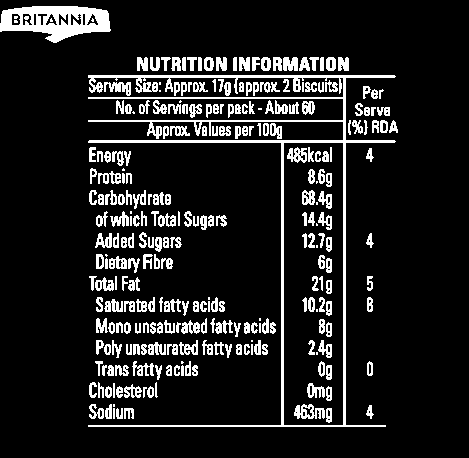

inv_req=True


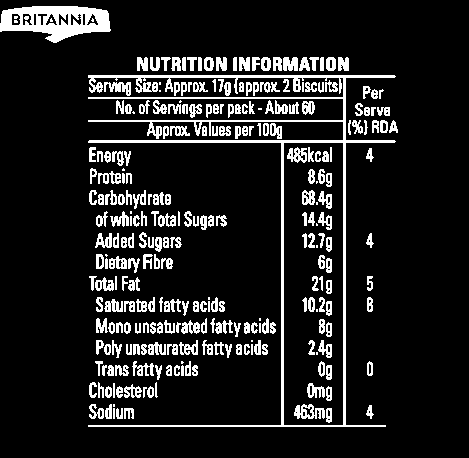

'<table>\n<tr>\n<td>  Britan </td>\n<td>  </td>\n</tr>\n<tr>\n<td>  </td>\n</tr>\n<tr>\n<td> Nutrition Information </td>\n</tr>\n<tr>\n<td>   </td>\n<td>  17G (Approx. 2 Biscuits)]  </td>\n<td>  Per </td>\n</tr>\n<tr>\n<td> No. Of Servings Per Pack - About 60 </td>\n<td>  Serve </td>\n</tr>\n<tr>\n<td>  Values Per 100G </td>\n<td>  (%) Rda </td>\n</tr>\n<tr>\n<td> Energy </td>\n<td> 485Kcal </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Protein </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Carbohydrate </td>\n<td>  684G  </td>\n</tr>\n<tr>\n<td> Of Which Total Sugars </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Added Sugars </td>\n<td>  </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Dietary Fibre </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Total Fat </td>\n<td>  </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Saturated Fatty Acids </td>\n<td>  </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Mono Unsaturated Fatty Acids  </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Poly Unsaturated Fatty Acids  </td>\n<td>  </td>\n</tr>\n<tr>\n<td> Trans Fatty Acids <

In [21]:
html_output("/content/britania.png")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Completeinv_req=False


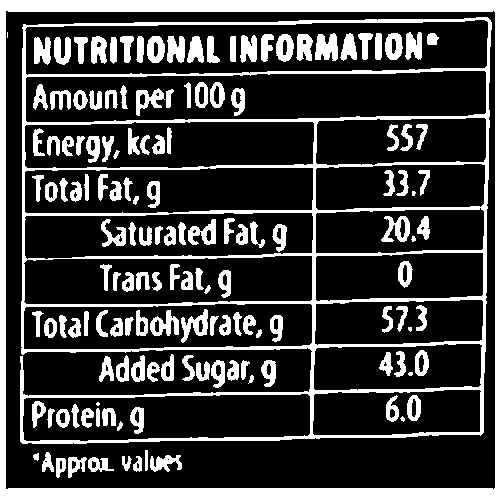

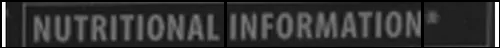

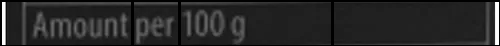

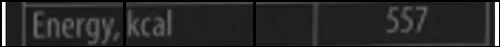

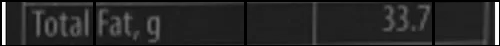

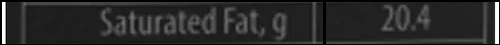

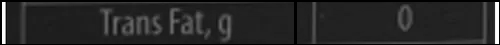

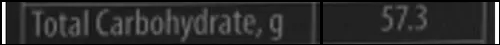

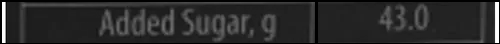

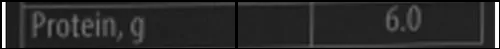

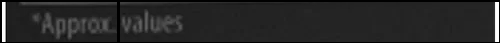

inv_req=False


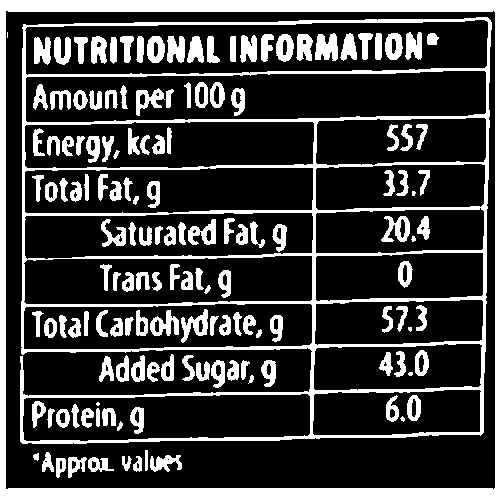

| (NUTRITIONAL INFORMATION*












In [7]:
# %%capture
data,col_boxes = img_to_table("//content/amul_dark.webp")

In [27]:
table=""
for row in data:
  table+="<tr>\n"
  table+=f"<td> {row} </td>\n"
  table+="</tr>\n"

In [29]:
(f"<table>\n{table}</table>")

'<table>\n<tr>\n<td> p=) "U0P-\\) IDI F-w\n\x0c </td>\n</tr>\n<tr>\n<td> Fe\n\x0c </td>\n</tr>\n<tr>\n<td> NUTRITION INFORMATION\n\x0c </td>\n</tr>\n<tr>\n<td> Serving Size: Approx. 17g (approx. 2 Biscuits) pp,\n\x0c </td>\n</tr>\n<tr>\n<td> No. of Servings per pack-About60 | Serve\n\x0c </td>\n</tr>\n<tr>\n<td> ‘Approx. Values per 100g (%) RDA\n\x0c </td>\n</tr>\n<tr>\n<td> Energy 485kcal | 4\n\x0c </td>\n</tr>\n<tr>\n<td> Protein | 86g |\n\x0c </td>\n</tr>\n<tr>\n<td> Carbohydrate | 684g |\n\x0c </td>\n</tr>\n<tr>\n<td> of which Total Sugars } 14.49 |\n\x0c </td>\n</tr>\n<tr>\n<td> Added Sugars |} 127g | 4\n\x0c </td>\n</tr>\n<tr>\n<td> Dietary Fibre | 69]\n\x0c </td>\n</tr>\n<tr>\n<td> Total Fat } 2g] 5\n\x0c </td>\n</tr>\n<tr>\n<td> Saturated fatty acids |} 102g | 8\n\x0c </td>\n</tr>\n<tr>\n<td> Mono unsaturated fatty acids} 8g |\n\x0c </td>\n</tr>\n<tr>\n<td> Poly unsaturated fatty acids | 2.49 |\n\x0c </td>\n</tr>\n<tr>\n<td> Trans fatty acids } Og} 0\n\x0c </td>\n</tr>\n<tr>\n<

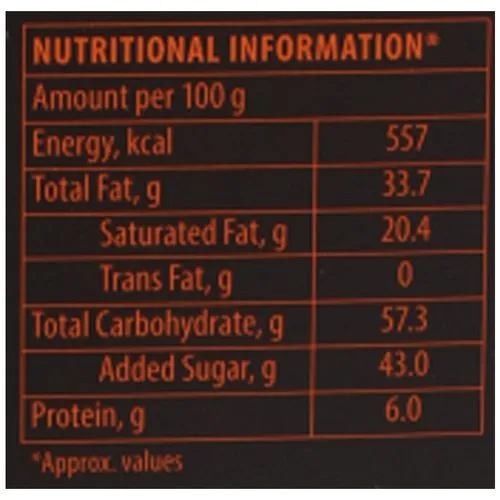

In [ ]:
cv2_imshow(cv2.imread("amul_dark.webp"))

In [ ]:
max(set(list(map(len,data))), key=list(map(len,data)).count)

2

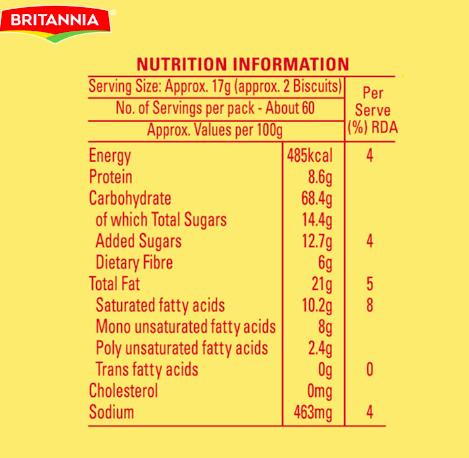

In [ ]:
cv2_imshow(cv2.imread("/content/britania.png"))

In [ ]:
for x in data:
  for y in x:
    print(y.replace("\n"," ").replace("|",""),sep=" ")

  

par 100g (Prodhct eppenx.) 
B Carbohydrates: 
  
= Ofwhich Sugars 
  
Dietary Finre 
  


m Fail 

= Saturated Fatty Acids 

‘Mono Unsaturated Fatty Acids 8.59 
= @6Poly Unsaturated Fatty Acids: 

= @6©©Trane Fatty Acids: 



  



inv_req=True


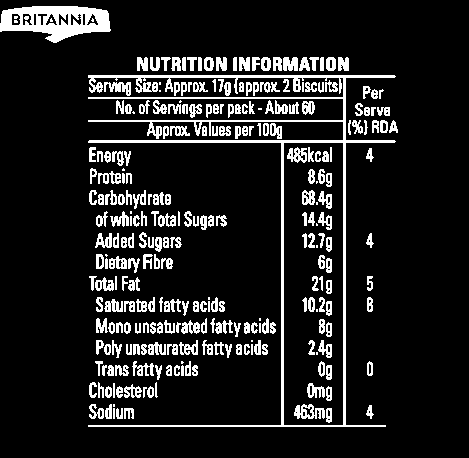

inv_req=True


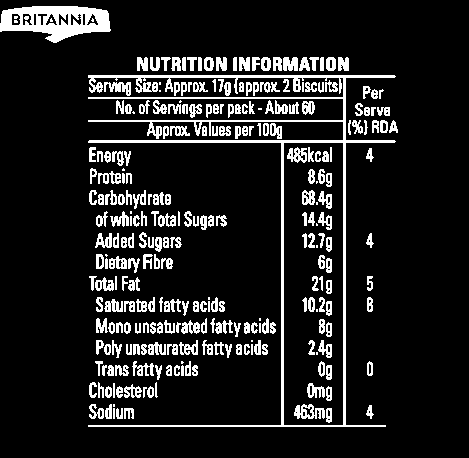

In [24]:
*_,data = img_to_table("/content/britania.png")